In [34]:
#melakukan import library yang dibutuhkan
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import datetime as dt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

#from sklearn.model_selection import train_test_split
#from keras.callbacks import EarlyStopping

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
# menuju ke alamat file
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [37]:
# Membaca dataset
df = pd.read_csv('TLKM.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2/5/2007,1910,1910,1890,1910,1241.967651,54545000
1,2/6/2007,1890,1900,1880,1890,1228.962524,39287500
2,2/7/2007,1870,1890,1860,1870,1215.957397,128965000
3,2/8/2007,1860,1860,1810,1860,1209.455444,188895000
4,2/9/2007,1840,1840,1810,1820,1183.445313,133475000
...,...,...,...,...,...,...,...
3559,7/5/2021,3070,3090,3010,3040,3040.000000,133815000
3560,7/6/2021,3050,3070,3000,3010,3010.000000,151573500
3561,7/7/2021,3030,3070,3010,3030,3030.000000,110215500
3562,7/8/2021,3060,3060,3000,3010,3010.000000,132576600


In [38]:
# Memeriksa data bernilai kosong/NaN/Null
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

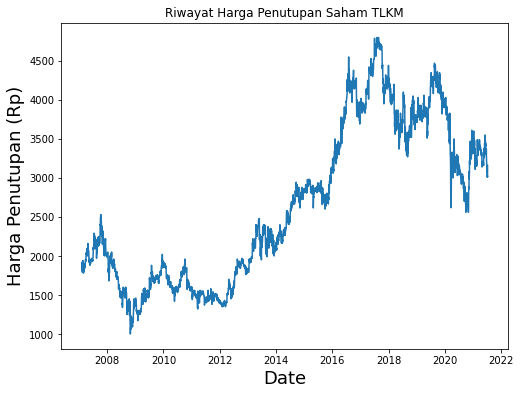

In [39]:
# Visualisasi data harga penutupan
plt.figure(figsize=(8,6))
plt.title('Riwayat Harga Penutupan Saham TLKM')
df['Date'] = pd.to_datetime(df['Date'])
plt.plot(df['Date'], df['Close'])

plt.xlabel('Date', fontsize=18)
plt.ylabel('Harga Penutupan (Rp)', fontsize=18)
plt.show()


In [40]:
data = df.filter(['Close'])
data

,Close
0,1910
1,1890
2,1870
3,1860
4,1820
...,...
3559,3040
3560,3010
3561,3030
3562,3010


In [41]:
data_min = min(df['Close'])
data_min

1000

In [42]:
data_max = max(df['Close'])
data_max

4800

In [43]:
data_len = data.values
data_len

array([[1910],
       [1890],
       [1870],
       ...,
       [3030],
       [3010],
       [3160]])

In [44]:
# Normalisasi data dengan range (0 - 1)
sc = MinMaxScaler(feature_range=(0, 1))
scaled_data = sc.fit_transform(data_len)
scaled_data

array([[0.23947368],
       [0.23421053],
       [0.22894737],
       ...,
       [0.53421053],
       [0.52894737],
       [0.56842105]])

In [45]:
# Split dataset
training_data = scaled_data[0:int(len(scaled_data) * 0.8)]
test_data = scaled_data[int(len(scaled_data) * 0.8):]

In [46]:
len(training_data)

2851

In [47]:
len(test_data)

713

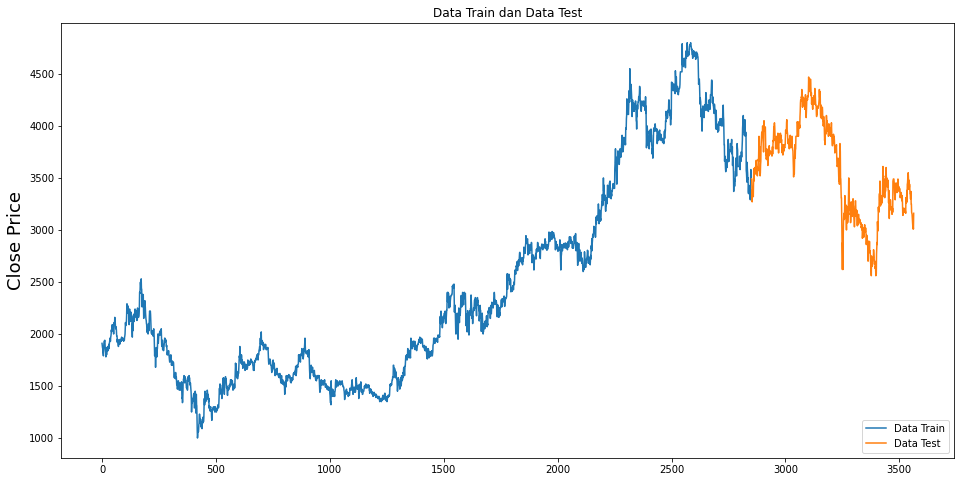

In [59]:
df_train = data[0:int(len(data)*0.8)]
df_test = data[int(len(data)*0.8):]

# plot the data
# Visualisasi data
plt.figure(figsize=(16,8))
plt.title('Data Train dan Data Test')
plt.ylabel('Close Price', fontsize=18)
plt.plot(df_train)
plt.plot(df_test)

plt.legend(['Data Train', 'Data Test'], loc='lower right')
plt.show()

In [51]:
# membuat struktur data X_train dengan 60 timesteps
X_train = []
y_train = []
for i in range(60, 2850):   
    X_train.append(training_data[i-60:i, 0])
    y_train.append(training_data[i, 0])  
    if i <= 60:
      print(X_train)
      print(y_train)
      print()

[array([0.23947368, 0.23421053, 0.22894737, 0.22631579, 0.21578947,
       0.21315789, 0.20789474, 0.22368421, 0.23684211, 0.24473684,
       0.24473684, 0.24473684, 0.24736842, 0.24210526, 0.22631579,
       0.22105263, 0.21578947, 0.20526316, 0.22368421, 0.22894737,
       0.21052632, 0.22368421, 0.22368421, 0.22631579, 0.22105263,
       0.23157895, 0.23157895, 0.22105263, 0.22894737, 0.22631579,
       0.23684211, 0.22631579, 0.23947368, 0.24210526, 0.24736842,
       0.25263158, 0.24736842, 0.24473684, 0.25526316, 0.25789474,
       0.26315789, 0.27368421, 0.26842105, 0.27368421, 0.27894737,
       0.28684211, 0.27631579, 0.28421053, 0.28421053, 0.28684211,
       0.27631579, 0.26315789, 0.28421053, 0.29210526, 0.28947368,
       0.28947368, 0.30526316, 0.30263158, 0.28947368, 0.28157895])]
[0.27631578947368424]



In [52]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [53]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(2790, 60, 1)

In [54]:
from keras import backend as K
def r2_keras(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))                                           
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res/(SS_tot + K.epsilon()))

In [55]:
model = Sequential()

#Adding the first LSTM  and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape [1], 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(1))

#Compiling the LSTM
model.compile(optimizer = 'adam', 
              loss = 'mean_absolute_error', 
              metrics=[r2_keras])

In [56]:
# Fitting LSTM ke data train
model.fit(X_train, y_train, epochs = 100, batch_size = 64)

Epoch 1/100
44/44 [==============================] - 13s 154ms/step - loss: 0.0933 - r2_keras: 0.6737
Epoch 2/100
44/44 [==============================] - 7s 152ms/step - loss: 0.0405 - r2_keras: 0.9501
Epoch 3/100
44/44 [==============================] - 7s 152ms/step - loss: 0.0381 - r2_keras: 0.9556
Epoch 4/100
44/44 [==============================] - 7s 153ms/step - loss: 0.0377 - r2_keras: 0.9570
Epoch 5/100
44/44 [==============================] - 7s 155ms/step - loss: 0.0343 - r2_keras: 0.9632
Epoch 6/100
44/44 [==============================] - 7s 161ms/step - loss: 0.0351 - r2_keras: 0.9628
Epoch 7/100
44/44 [==============================] - 7s 157ms/step - loss: 0.0333 - r2_keras: 0.9656
Epoch 8/100
44/44 [==============================] - 7s 157ms/step - loss: 0.0349 - r2_keras: 0.9632
Epoch 9/100
44/44 [==============================] - 7s 155ms/step - loss: 0.0345 - r2_keras: 0.9638
Epoch 10/100
44/44 [==============================] - 7s 157ms/step - loss: 0.0337 - r2_ke

In [60]:
total_data = pd.concat((df_train, df_test), axis=0)
inputs = total_data[len(total_data) - len(df_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
print(len(inputs))

773


In [68]:
# membuat struktur data X_test dengan 60 timesteps
X_test = []

for i in range(60, 773):
  X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [69]:
predicted_stock_close_price = model.predict(X_test)
predicted_stock_close_price = sc.inverse_transform(
    predicted_stock_close_price)
print(len(predicted_stock_close_price))

713


In [70]:
prediction = np.array(predicted_stock_close_price)
df_hasil = pd.DataFrame()
df_hasil['Real Price'] = df_test['Close'].reset_index(drop = True)
df_hasil['Prediction'] = prediction
df_hasil

,Real Price,Prediction
0,3490,3546.897217
1,3490,3537.741211
2,3420,3528.095215
3,3270,3502.534912
4,3360,3437.234863
...,...,...
708,3040,3164.481445
709,3010,3132.234375
710,3030,3100.777832
711,3010,3085.755371


In [ ]:
df_hasil.to_excel("datatest_stock(60neuron).xlsx")

In [71]:
# Besar nilai kesalahan 
mape = np.mean(np.abs((df_hasil['Real Price'] - 
                       df_hasil['Prediction'])/df_hasil['Real Price'])) * 100
print('Mean Absolute Percentage Error : ' "{:.2f}".format(mape)+'%')

Mean Absolute Percentage Error : 1.96%


In [72]:
# Besar nilai akurasi dengan R Squared
r2 = r2_score(df_hasil['Real Price'], df_hasil['Prediction'])
r2 = r2 * 100
print ('Skor Akurasi (R Squared) : ' "{:.2f}".format(r2)+' %')

Skor Akurasi (R Squared) : 95.99 %


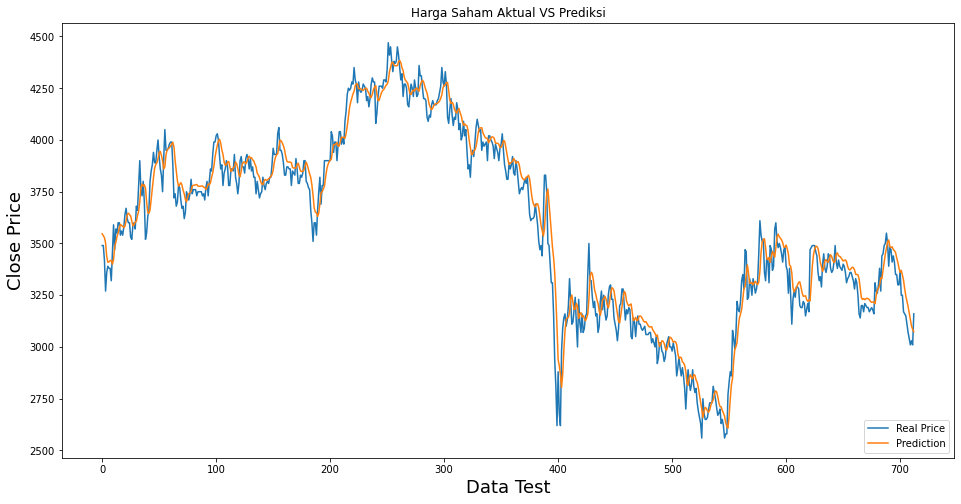

In [73]:
# Visualisasi prediksi
plt.figure(figsize=(16,8))
plt.title('Harga Saham Aktual VS Prediksi')
plt.xlabel('Data Test', fontsize=18)
plt.ylabel('Close Price', fontsize=18)

plt.plot(df_hasil['Real Price'])
plt.plot(df_hasil['Prediction'])
plt.legend(['Real Price', 'Prediction'], loc='lower right')
plt.show()

In [75]:
# Prediksi 1 hari berikutnya pada 12 Juli 2021
real_data = [inputs[len(inputs) + 1 - 60:len(inputs+1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], 
                                   real_data.shape[1],1))

prediction = model.predict(real_data)
prediction = sc.inverse_transform(prediction)
print(f"Prediksi harga penutupan saham untuk 12 Juli 2021 : {prediction}")

Prediksi harga penutupan saham untuk 12 Juli 2021 : [[3111.9978]]


**-----END of PROJECT------**